In [51]:
import pandas as pd

df = pd.read_csv('bank+marketing/bank-additional/bank-additional-full.csv', delimiter=';')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [52]:
cols_to_drop = ['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
df = df.drop(columns=cols_to_drop)
df = df.rename(columns={'job': 'job_type', 'default': 'default_status', 
                                                   'housing': 'housing_loan_status', 'loan': 'personal_loan_status', 
                                                   'contact': 'contact_type', 'month': 'contact_month', 
                                                   'day_of_week': 'contact_day_of_week', 'campaign': 'num_contacts', 
                                                   'pdays': 'days_last_contact', 'previous': 'previous_contacts', 
                                                   'poutcome': 'previous_outcome', 
                                                   'y': 'result'
                                                    })
df['result'] = df['result'].replace({'yes': 1, 'no': 0})
df.head()



,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [53]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Select the columns to encode
one_hot_columns = ['contact_type', 'marital', 'default_status', 'housing_loan_status', 'personal_loan_status', 'previous_outcome']

# Extract the selected columns from the DataFrame
data_to_encode = df[one_hot_columns]

# Transform the selected columns using the encoder
encoded_data = encoder.fit_transform(data_to_encode).toarray()

# Create a new DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(one_hot_columns))

# Concatenate the encoded DataFrame with the original DataFrame
df = pd.concat([df.drop(one_hot_columns, axis=1), encoded_df], axis=1)


In [54]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='result')
y = df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)




In [55]:
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import lightgbm as lgb

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


ordinal_columns = ['contact_month', 'contact_day_of_week']
lbl_bin_columns = ['job_type', 'education']
ordinal_encoder = OrdinalEncoder(categories=[
                                              ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                                              ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
                                            ]
                                )
# one_hot_encoder = OneHotEncoder(sparse_output=False)
lbl_bin_encoder = ce.BinaryEncoder()
ct = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_encoder, ordinal_columns),
            # ('onehot', one_hot_encoder, one_hot_columns),
            ('binary', lbl_bin_encoder, lbl_bin_columns),
        ],
        remainder='passthrough'
    )
pipe = Pipeline(steps=
                [
                  ('preprocess', ct),
                  # ('clf', XGBClassifier(random_state=8))
                  ('clf', lgb.LGBMClassifier(random_state=8))
                ]
              )

# search_space = {
#     'clf__max_depth': Integer(2,8, dtype=np.int16),
#     'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
#     'clf__subsample': Real(0.5, 1.0),
#     'clf__colsample_bytree': Real(0.5, 1.0),
#     'clf__colsample_bylevel': Real(0.5, 1.0),
#     'clf__colsample_bynode' : Real(0.5, 1.0),
#     'clf__reg_alpha': Real(0.0, 10.0),
#     'clf__reg_lambda': Real(0.0, 10.0),
#     'clf__gamma': Real(0.0, 10.0),
#     'clf__n_estimators': Integer(100, 200)
# }
search_space = {
    'clf__boosting_type': Categorical(['gbdt', 'dart']),
    'clf__num_iterations': Integer(50, 500),
    'clf__learning_rate': Real(10**-5, 1, "log-uniform"),
    'clf__max_depth': Integer(-1, 15),
    'clf__min_data_in_leaf': Integer(10, 100),
    'clf__feature_fraction': Real(0.1, 1.0),
    'clf__bagging_fraction': Real(0.1, 1.0),
    'clf__bagging_freq': Integer(0, 5),
    'clf__lambda_l1': Real(10**-10, 1, "log-uniform"),
    'clf__lambda_l2': Real(10**-10, 1, "log-uniform"),
    'clf__min_gain_to_split': Real(0, 1),
    'clf__num_leaves': Integer(10, 100),
    'clf__max_bin': Integer(100, 500),
    'clf__min_data_in_bin': Integer(1, 50),
    'clf__cat_l2': Real(10**-10, 1, "log-uniform"),
    'clf__cat_smooth': Real(10**-10, 1, "log-uniform")
}
opt = BayesSearchCV(pipe, search_space, scoring='accuracy', random_state=8, verbose=True) 
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=Pipeline(steps=[('preprocess',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('ordinal',
                                                                          OrdinalEncoder(categories=[['jan',
                                                                                                      'feb',
                                                                                                      'mar',
                                                                                                      'apr',
                                                                                                      'may',
                                                                                                      'jun',
                                                                                                      'jul',
                                                                                                      'aug',
                                                                                                      'sep',
                                                                                                      'oct',
                                                                                                      'nov',
                                                                                                      'dec'],
                                                                                                     ['mon',
                                                                                                      'tue',
                                                                                                      'wed',
                                                                                                      'thu',
                                                                                                      'fri',
                                                                                                      'sat',
                                                                                                      'sun']]),
                                                                          ['contact_month',
                                                                           'contact_day_of_week']),
                                                                         ('binary',
                                                                          BinaryEncoder(),
                                                                          ['job_type',
                                                                           'ed...
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__n_estimators': Integer(low=100, high=200, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=True)

In [56]:
opt.best_estimator_


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['jan',
                                                                              'feb',
                                                                              'mar',
                                                                              'apr',
                                                                              'may',
                                                                              'jun',
                                                                              'jul',
                                                                              'aug',
                                                                              'sep',
                                                                              'oct',
                                                                              'nov',
                                                                              'dec'],
                                                                             ['mon',
                                                                              'tue',
                                                                              'wed',
                                                                              'thu',
                                                                              'fri',
                                                                              'sat',
                                                                              'sun']]),
                                                  ['contact_month',
                                                   'contact_day_of_week']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job_type', 'education'])])),
                ('clf',
                 XGB...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0716718903838158, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=141, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=8, ...))])

In [57]:
opt.best_score_

0.8982701062215478

In [58]:
opt.score(X_test, y_test)

0.9005826656955572

In [59]:
opt.predict(X_test)


array([0, 0, 0, ..., 0, 0, 0])

In [60]:
opt.predict_proba(X_test)

array([[0.94047576, 0.05952423],
       [0.96164465, 0.03835532],
       [0.9416085 , 0.05839153],
       ...,
       [0.6394149 , 0.36058512],
       [0.96334213, 0.03665784],
       [0.87284315, 0.12715688]], dtype=float32)

In [61]:
opt.best_estimator_.steps

[('preprocess',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('ordinal',
                                   OrdinalEncoder(categories=[['jan', 'feb',
                                                               'mar', 'apr',
                                                               'may', 'jun',
                                                               'jul', 'aug',
                                                               'sep', 'oct',
                                                               'nov', 'dec'],
                                                              ['mon', 'tue',
                                                               'wed', 'thu',
                                                               'fri', 'sat',
                                                               'sun']]),
                                   ['contact_month', 'contact_day_of_week']),
                                  ('binary', Bin

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

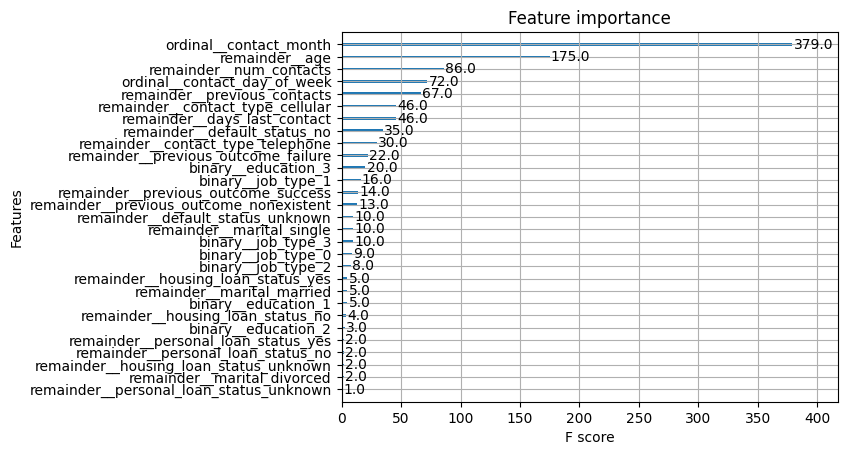

In [62]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
xgboost_model.get_booster().feature_names = opt.best_estimator_.named_steps.preprocess.get_feature_names_out().tolist()
plot_importance(xgboost_model)

In [63]:
ct = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_encoder, ordinal_columns),
            ('binary', lbl_bin_encoder, lbl_bin_columns),
        ],
        remainder='passthrough'
    )

transformed_data = ct.fit_transform(X_train)
d = pd.DataFrame(transformed_data)
d.columns = ct.get_feature_names_out()
d.head()
d.dtypes
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ordinal__contact_month                   32950 non-null  float64
 1   ordinal__contact_day_of_week             32950 non-null  float64
 2   binary__job_type_0                       32950 non-null  float64
 3   binary__job_type_1                       32950 non-null  float64
 4   binary__job_type_2                       32950 non-null  float64
 5   binary__job_type_3                       32950 non-null  float64
 6   binary__education_0                      32950 non-null  float64
 7   binary__education_1                      32950 non-null  float64
 8   binary__education_2                      32950 non-null  float64
 9   binary__education_3                      32950 non-null  float64
 10  remainder__age                           32950

In [64]:
y_train.head()
y_train.dtypes

dtype('int64')